In [1]:
from google.colab import drive

# Google Drive를 Colab 가상 머신에 마운트합니다.
# 실행 시 인증 코드를 입력하라는 메시지가 나타날 수 있습니다.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# base_path = '/content/drive/MyDrive/2025-2 학부연구/'

# train_path = f"{base_path}/simulation-train_data"
# test_path = f"{base_path}/real-test_data"

train_path = '/content/drive/MyDrive/2025-2 학부연구/simulation-train_data'
test_path = '/content/drive/MyDrive/2025-2 학부연구/real-test_data'

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import time
import os

# Confusion Matrix를 위한 라이브러리 추가
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# --- 1. 기본 설정 및 장치 확인 ---
batch_size = 128 # gpu 따라서 설정하기 (32, 64, 128, 256, 512 이하)
# 전용 gpu 사용률 -> 9.4 ~ 9.6 GB(배치 256 사용 시)
num_epoch = 100
learning_rate = 0.001
FILE_PATH = 'resnet_trained_weights.pth'

In [4]:
# --- 5. 검증 함수 정의 (수정) ---
def validate_model(model, test_loader, device, class_names, epoch_num=None):
    """테스트 데이터셋에 대한 정확도와 Confusion Matrix를 계산하고 출력합니다."""
    model.eval()
    correct = 0
    total = 0

    # Confusion Matrix 계산을 위한 리스트
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for image, label in test_loader:
            x = image.to(device)
            y_ = label.to(device)

            output = model.forward(x)
            _, predicted_index = torch.max(output, 1)

            total += label.size(0)
            correct += (predicted_index == y_).sum().item()

            # 리스트에 정답과 예측 값을 추가
            all_labels.extend(y_.cpu().numpy())
            all_preds.extend(predicted_index.cpu().numpy())

    accuracy = 100 * correct / total
    model.train()

    # Confusion Matrix 계산
    cm = confusion_matrix(all_labels, all_preds)

    # Confusion Matrix 출력
    plt.figure(figsize=(8, 6))
    title = f"Confusion Matrix (Epoch {epoch_num if epoch_num is not None else 'Final'})"
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(title)
    plt.show()

    return accuracy

In [5]:
    # --- 2. 데이터 로딩 및 ImageNet 정규화 (생략) ---
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)])

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"사용 장치: {device}")

# train_path = "C:/2025-2 학부연구-ResNet 구현/ResNet-simulation-sample"
# test_path = "C:/2025-2 학부연구-ResNet 구현/ResNet-real-sample"
train_path = '/content/drive/MyDrive/2025-2 학부연구/simulation-train_data'
test_path = '/content/drive/MyDrive/2025-2 학부연구/real-test_data'
if not (os.path.exists(train_path) and os.path.exists(test_path)):
    print("Error: train_path 또는 test_path 경로를 확인해주세요.")

# load Dataset (train -> simulation, test -> real)
train_data = dset.ImageFolder(root=train_path, transform=transform)
test_data = dset.ImageFolder(root=test_path, transform=transform)

# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
# test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=0)
num_classes = len(train_data.classes)
print(f"데이터셋 클래스 수: {num_classes}")

class_names = train_data.classes
print(f"클래스 이름: {class_names}")


# --- 3. 모델 로드 및 수정 (생략) ---
# ... 이전 코드와 동일 ...
model = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)


# --- 4. 손실 함수 및 옵티마이저 설정 (생략) ---
# ... 이전 코드와 동일 ...
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

사용 장치: cuda:0
데이터셋 클래스 수: 3
클래스 이름: ['False', 'True', 'Unknown']



 학습 시작 



Total Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

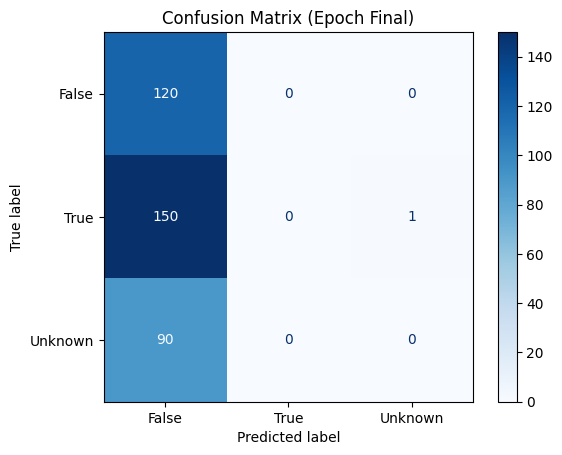

Epoch 1/100, Train Loss: 0.623197, Test Acc: 33.24% (Time: 6.73s)
-> Model saved with improved accuracy: 33.24%


Epoch 2/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

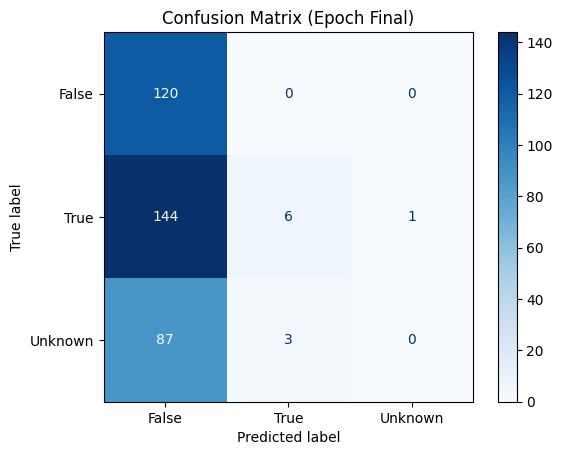

Epoch 2/100, Train Loss: 0.090913, Test Acc: 34.90% (Time: 4.35s)
-> Model saved with improved accuracy: 34.90%


Epoch 3/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

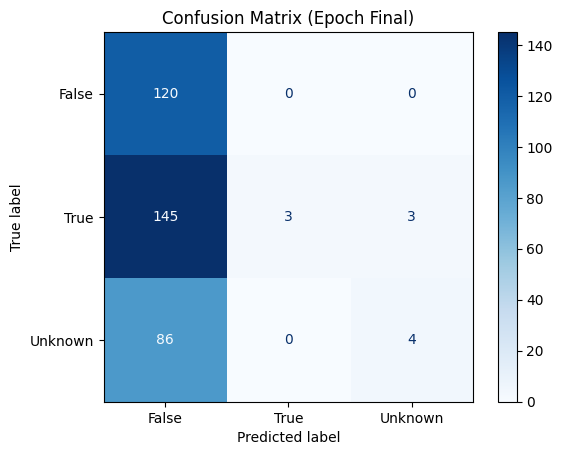

Epoch 3/100, Train Loss: 0.042075, Test Acc: 35.18% (Time: 4.80s)
-> Model saved with improved accuracy: 35.18%


Epoch 4/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

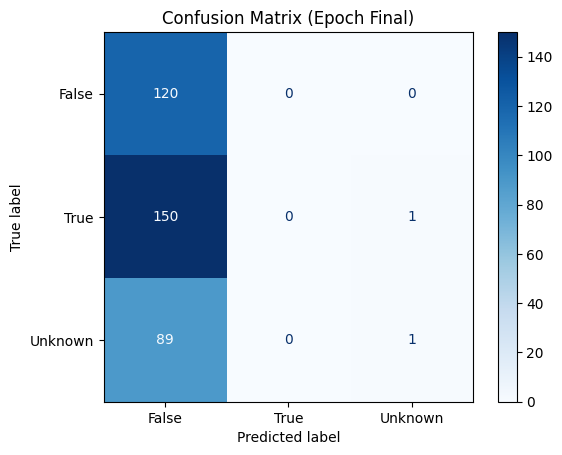

Epoch 4/100, Train Loss: 0.040295, Test Acc: 33.52% (Time: 4.42s)


Epoch 5/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

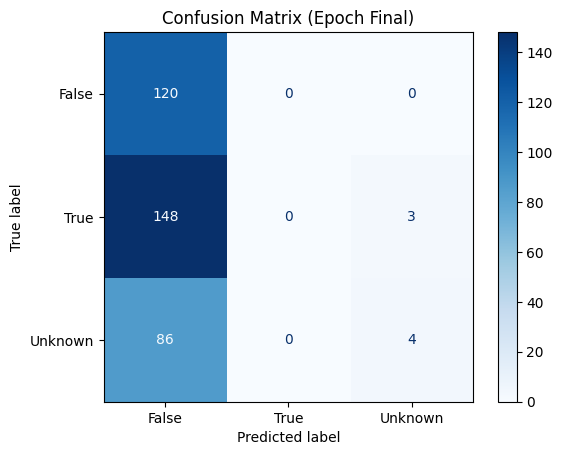

Epoch 5/100, Train Loss: 0.056795, Test Acc: 34.35% (Time: 4.69s)


Epoch 6/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

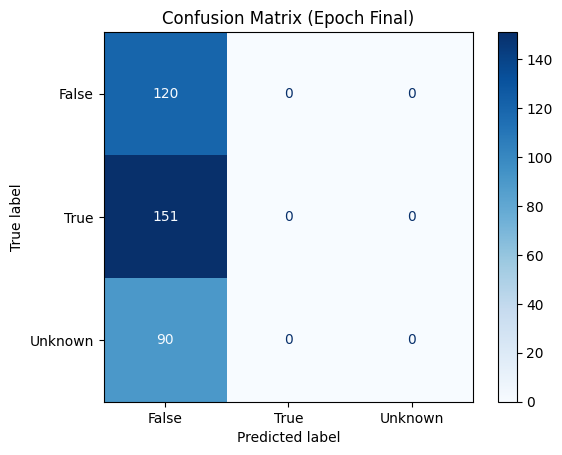

Epoch 6/100, Train Loss: 0.096160, Test Acc: 33.24% (Time: 4.13s)


Epoch 7/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

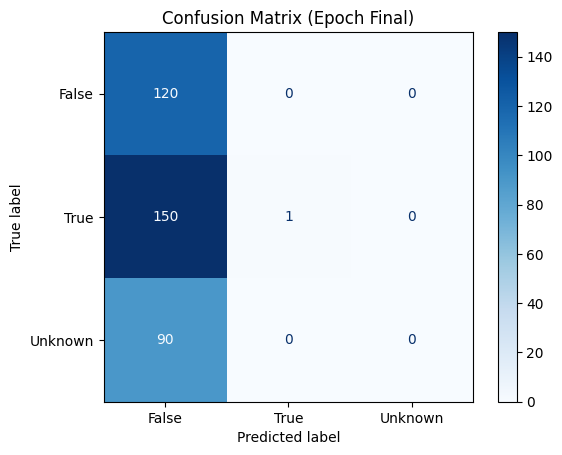

Epoch 7/100, Train Loss: 0.054878, Test Acc: 33.52% (Time: 4.83s)


Epoch 8/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

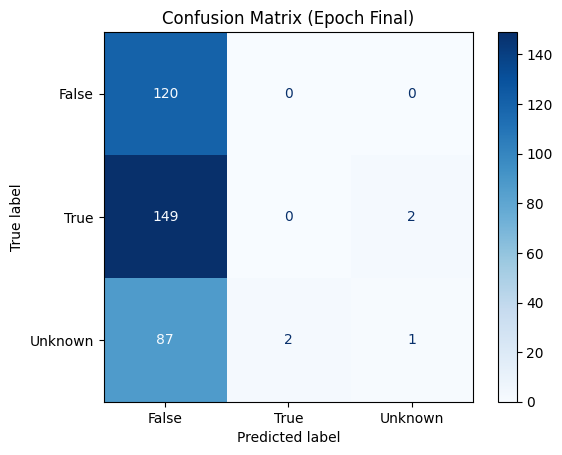

Epoch 8/100, Train Loss: 0.029742, Test Acc: 33.52% (Time: 4.23s)


Epoch 9/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

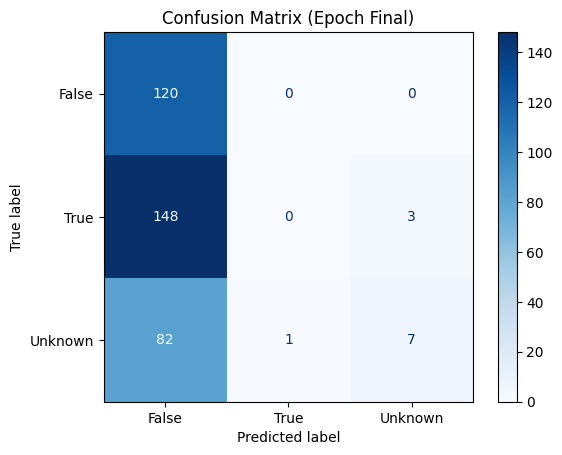

Epoch 9/100, Train Loss: 0.020001, Test Acc: 35.18% (Time: 4.78s)


Epoch 10/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

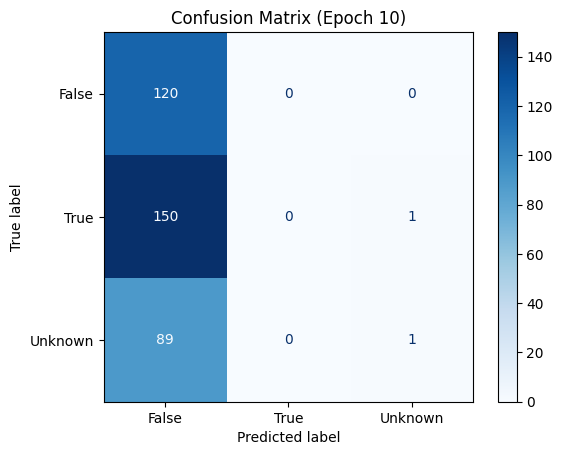

Epoch 10/100, Train Loss: 0.028967, Test Acc: 33.52% (Time: 4.16s, CM Plotted)


Epoch 11/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

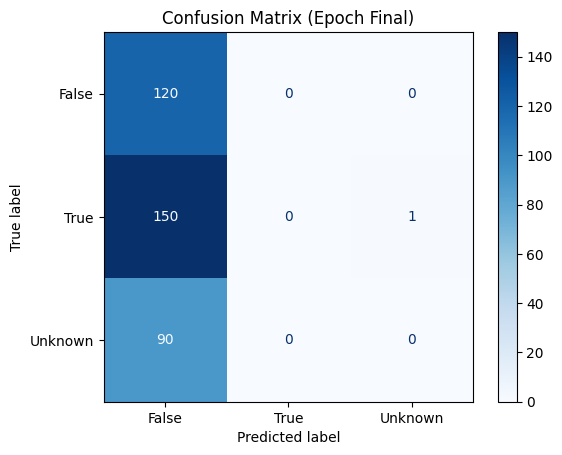

Epoch 11/100, Train Loss: 0.005649, Test Acc: 33.24% (Time: 4.75s)


Epoch 12/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

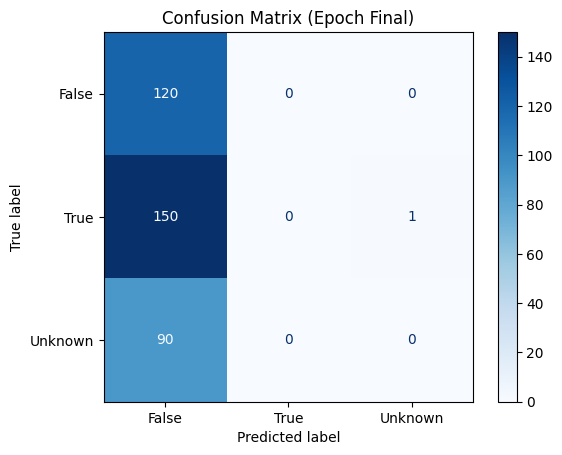

Epoch 12/100, Train Loss: 0.007856, Test Acc: 33.24% (Time: 4.64s)


Epoch 13/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

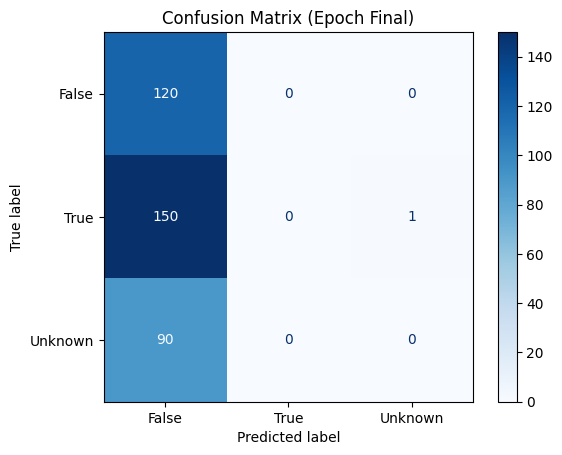

Epoch 13/100, Train Loss: 0.002406, Test Acc: 33.24% (Time: 4.82s)


Epoch 14/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

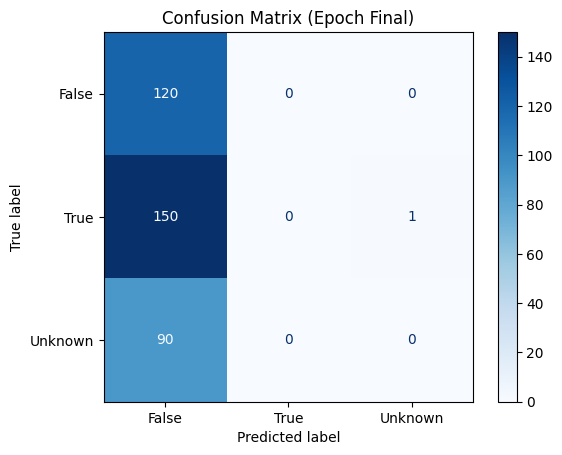

Epoch 14/100, Train Loss: 0.004614, Test Acc: 33.24% (Time: 4.25s)


Epoch 15/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

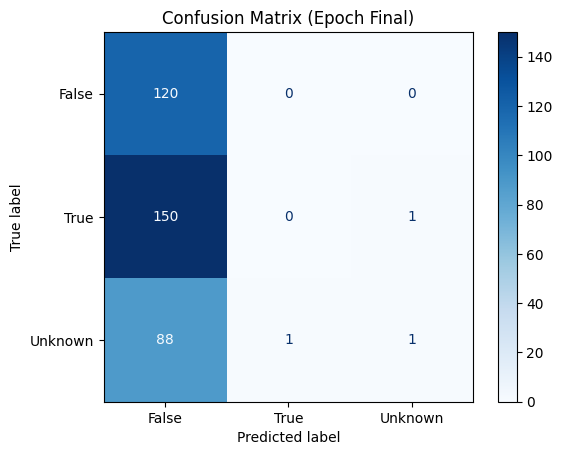

Epoch 15/100, Train Loss: 0.009156, Test Acc: 33.52% (Time: 4.76s)


Epoch 16/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

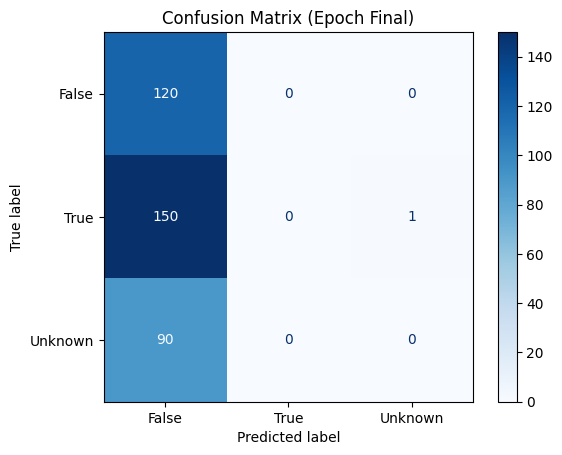

Epoch 16/100, Train Loss: 0.016215, Test Acc: 33.24% (Time: 4.34s)


Epoch 17/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

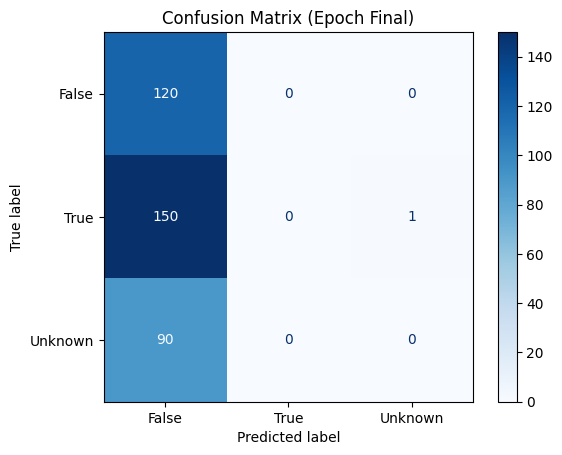

Epoch 17/100, Train Loss: 0.014514, Test Acc: 33.24% (Time: 4.80s)


Epoch 18/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

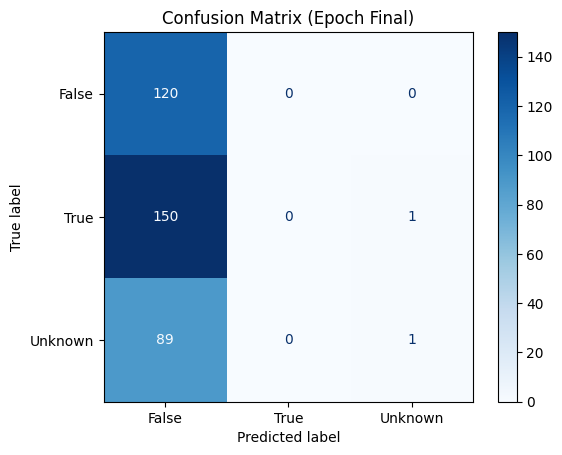

Epoch 18/100, Train Loss: 0.004090, Test Acc: 33.52% (Time: 4.24s)


Epoch 19/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

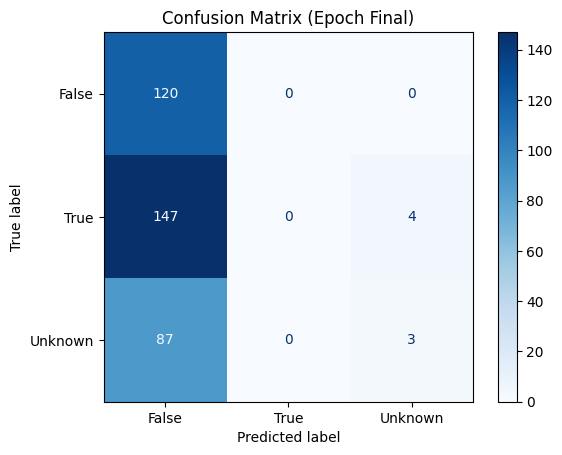

Epoch 19/100, Train Loss: 0.003044, Test Acc: 34.07% (Time: 4.92s)


Epoch 20/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

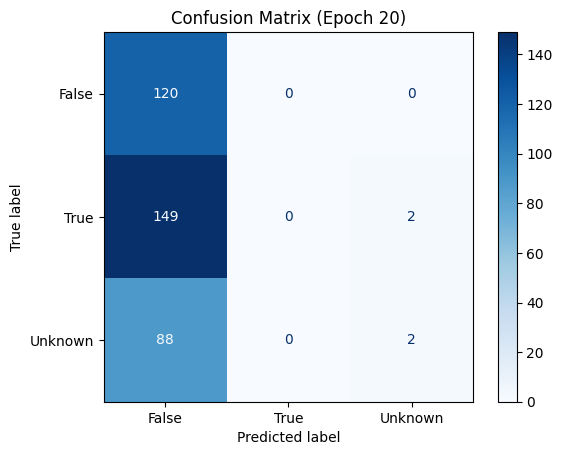

Epoch 20/100, Train Loss: 0.001482, Test Acc: 33.80% (Time: 4.21s, CM Plotted)


Epoch 21/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

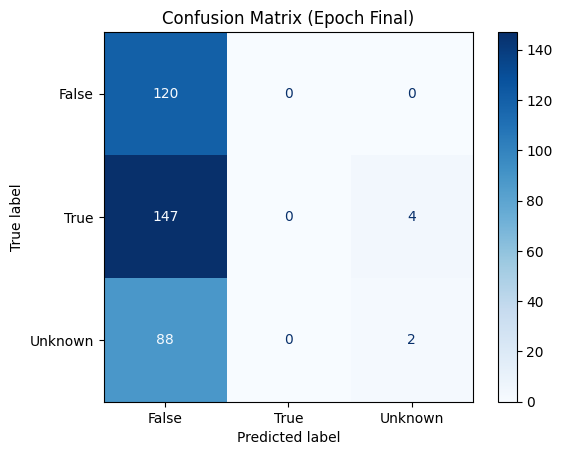

Epoch 21/100, Train Loss: 0.000650, Test Acc: 33.80% (Time: 4.82s)


Epoch 22/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

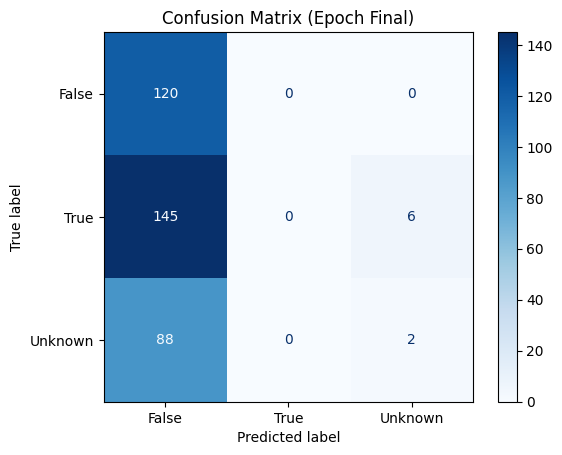

Epoch 22/100, Train Loss: 0.000621, Test Acc: 33.80% (Time: 4.27s)


Epoch 23/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

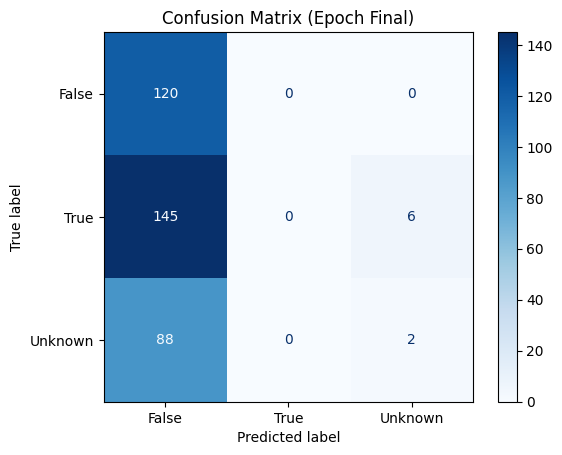

Epoch 23/100, Train Loss: 0.000542, Test Acc: 33.80% (Time: 4.63s)


Epoch 24/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

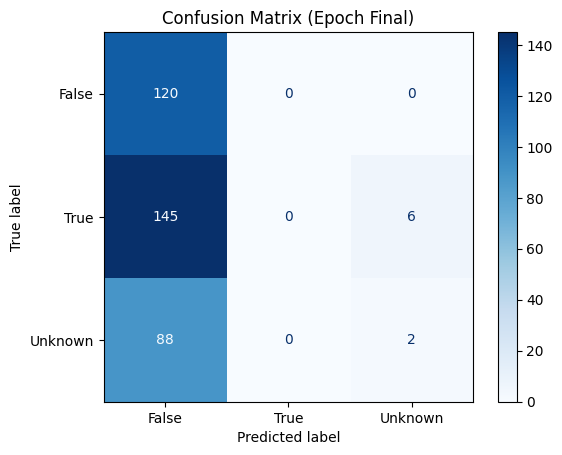

Epoch 24/100, Train Loss: 0.000337, Test Acc: 33.80% (Time: 4.28s)


Epoch 25/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

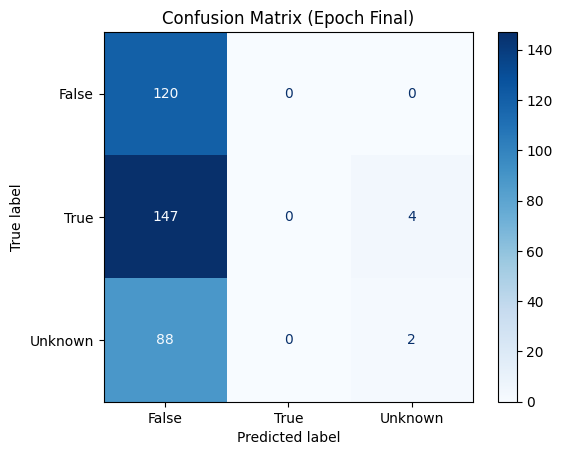

Epoch 25/100, Train Loss: 0.000347, Test Acc: 33.80% (Time: 4.69s)


Epoch 26/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

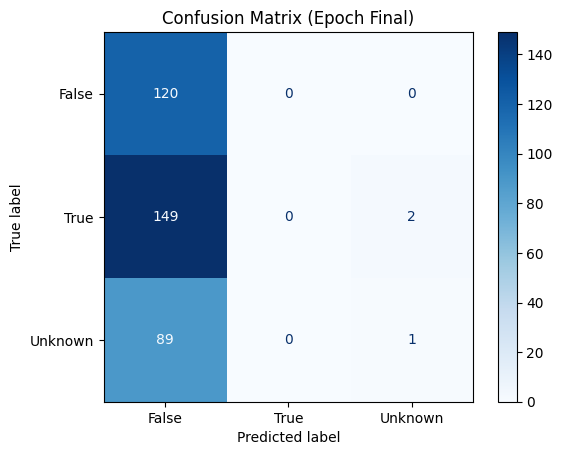

Epoch 26/100, Train Loss: 0.000298, Test Acc: 33.52% (Time: 4.26s)


Epoch 27/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

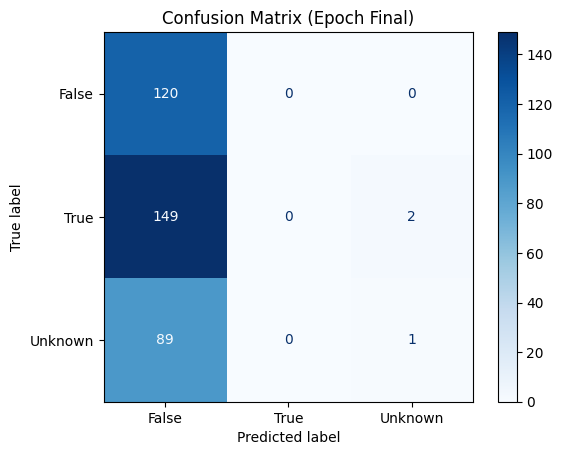

Epoch 27/100, Train Loss: 0.000227, Test Acc: 33.52% (Time: 4.55s)


Epoch 28/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

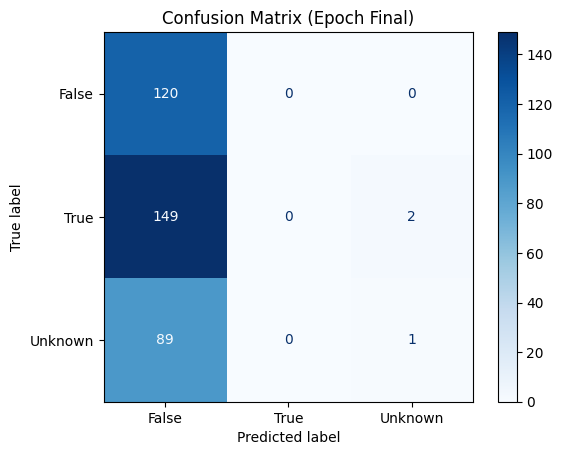

Epoch 28/100, Train Loss: 0.000295, Test Acc: 33.52% (Time: 4.24s)


Epoch 29/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

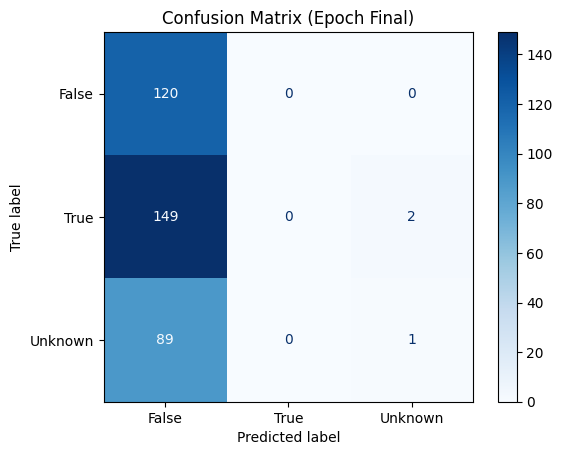

Epoch 29/100, Train Loss: 0.000235, Test Acc: 33.52% (Time: 4.43s)


Epoch 30/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

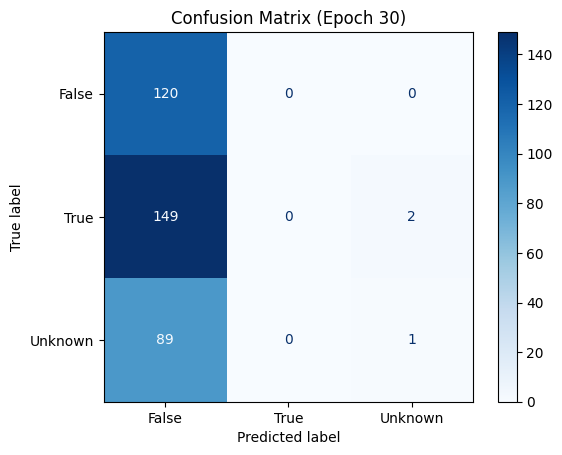

Epoch 30/100, Train Loss: 0.000173, Test Acc: 33.52% (Time: 4.34s, CM Plotted)


Epoch 31/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

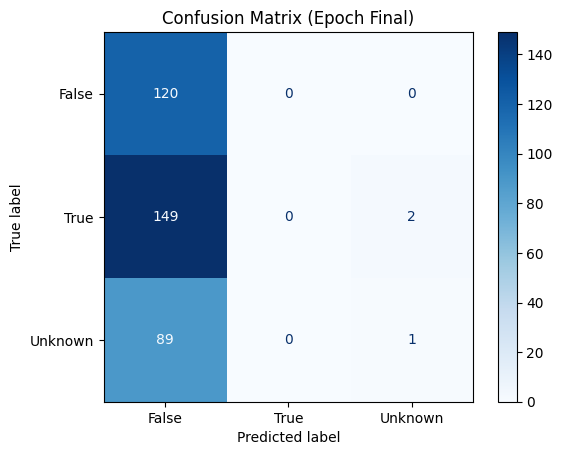

Epoch 31/100, Train Loss: 0.000199, Test Acc: 33.52% (Time: 5.01s)


Epoch 32/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

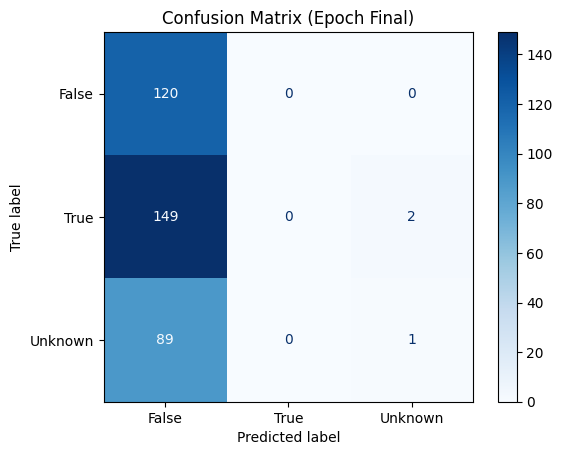

Epoch 32/100, Train Loss: 0.000166, Test Acc: 33.52% (Time: 4.26s)


Epoch 33/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

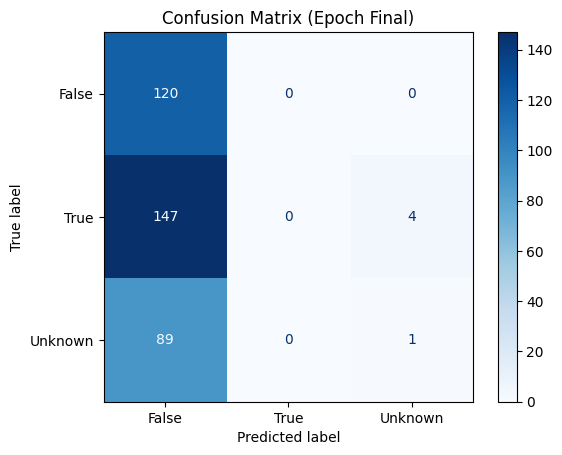

Epoch 33/100, Train Loss: 0.000169, Test Acc: 33.52% (Time: 4.76s)


Epoch 34/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

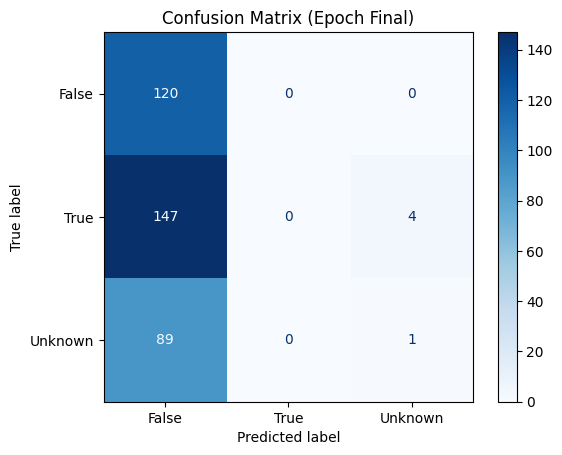

Epoch 34/100, Train Loss: 0.000123, Test Acc: 33.52% (Time: 4.24s)


Epoch 35/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

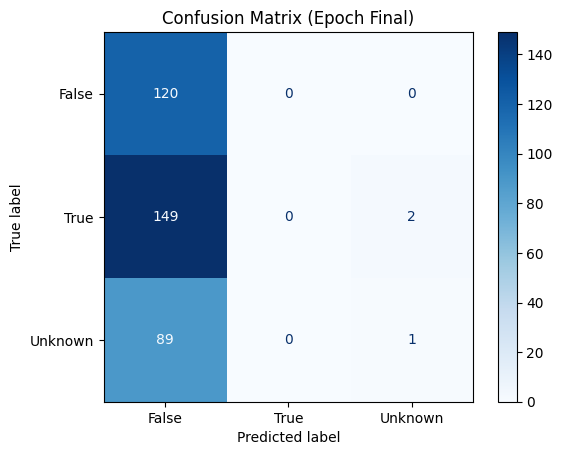

Epoch 35/100, Train Loss: 0.000142, Test Acc: 33.52% (Time: 4.68s)


Epoch 36/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

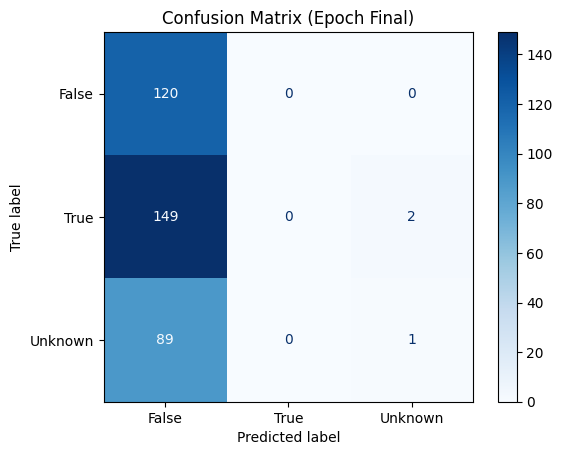

Epoch 36/100, Train Loss: 0.000111, Test Acc: 33.52% (Time: 4.33s)


Epoch 37/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

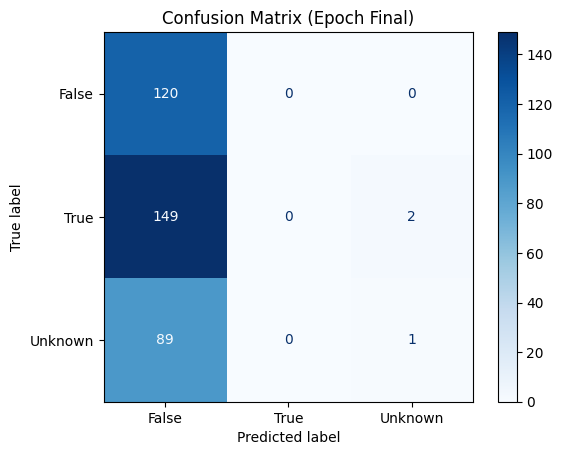

Epoch 37/100, Train Loss: 0.000129, Test Acc: 33.52% (Time: 4.59s)


Epoch 38/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

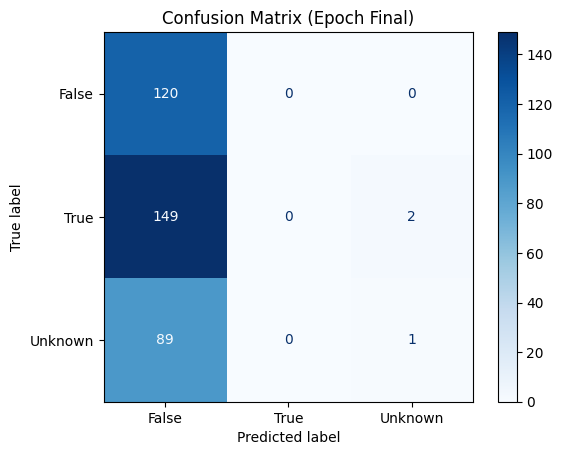

Epoch 38/100, Train Loss: 0.000104, Test Acc: 33.52% (Time: 4.29s)


Epoch 39/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

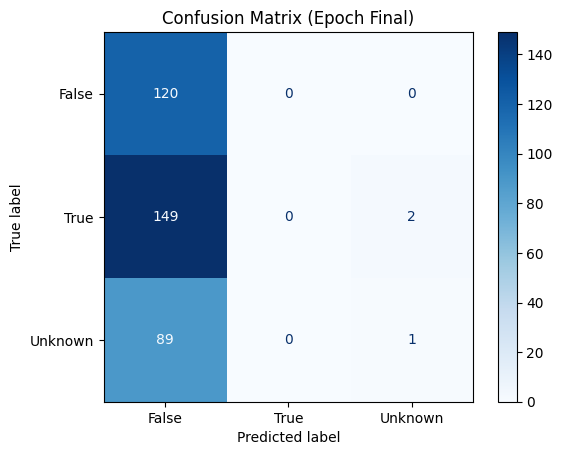

Epoch 39/100, Train Loss: 0.000108, Test Acc: 33.52% (Time: 4.74s)


Epoch 40/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

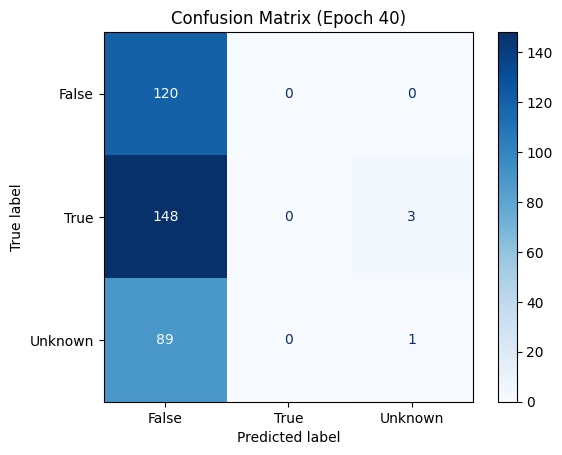

Epoch 40/100, Train Loss: 0.000122, Test Acc: 33.52% (Time: 4.23s, CM Plotted)


Epoch 41/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

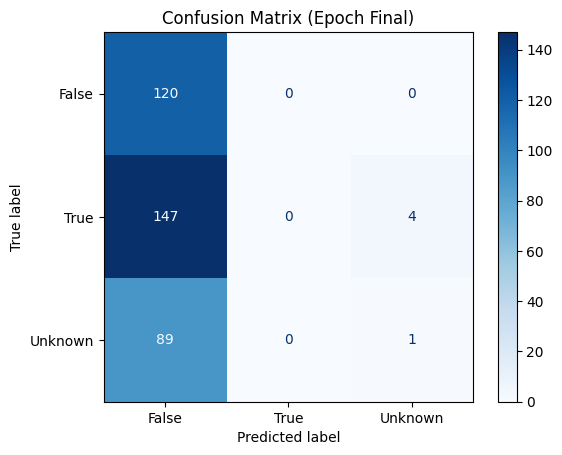

Epoch 41/100, Train Loss: 0.000095, Test Acc: 33.52% (Time: 4.66s)


Epoch 42/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

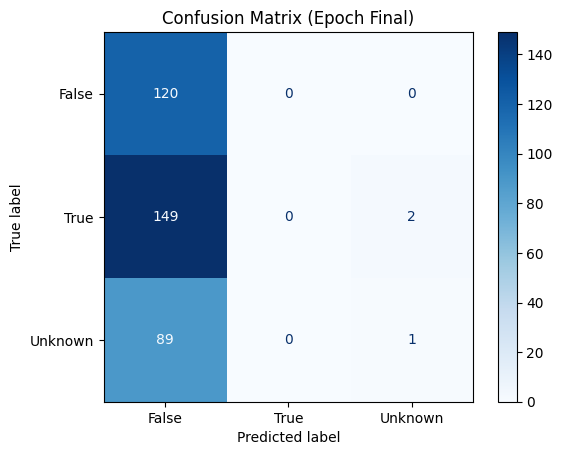

Epoch 42/100, Train Loss: 0.000089, Test Acc: 33.52% (Time: 4.28s)


Epoch 43/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

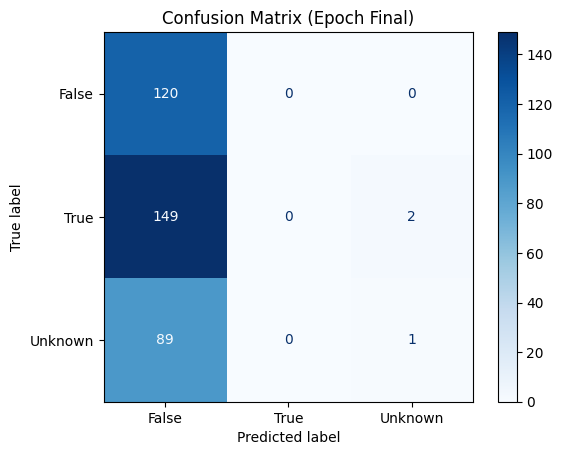

Epoch 43/100, Train Loss: 0.000069, Test Acc: 33.52% (Time: 4.62s)


Epoch 44/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

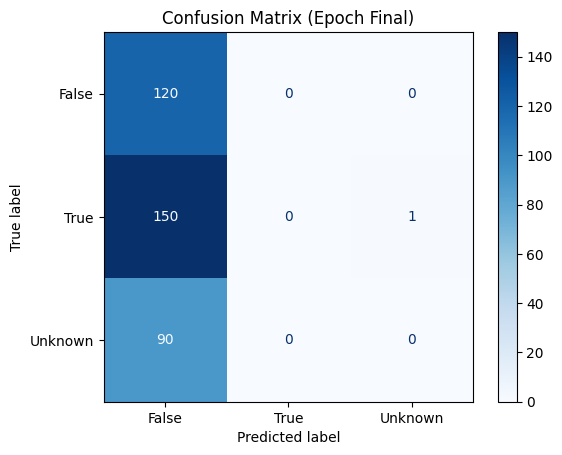

Epoch 44/100, Train Loss: 0.000149, Test Acc: 33.24% (Time: 4.30s)


Epoch 45/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

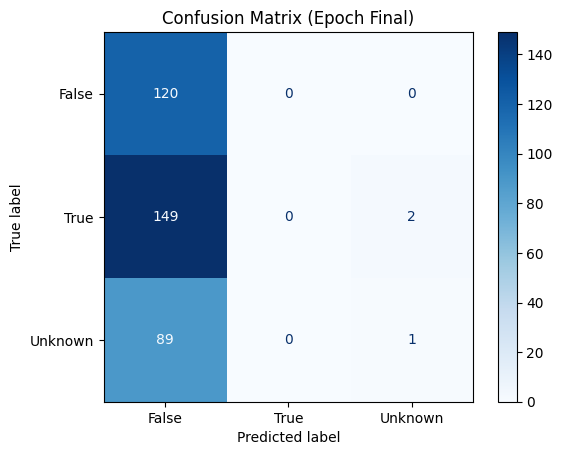

Epoch 45/100, Train Loss: 0.000072, Test Acc: 33.52% (Time: 4.55s)


Epoch 46/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

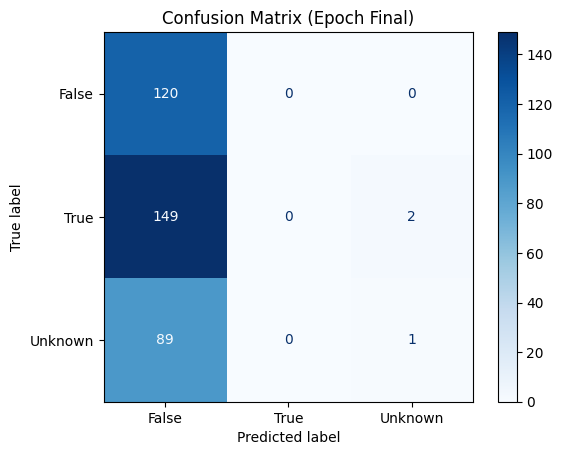

Epoch 46/100, Train Loss: 0.000079, Test Acc: 33.52% (Time: 4.29s)


Epoch 47/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

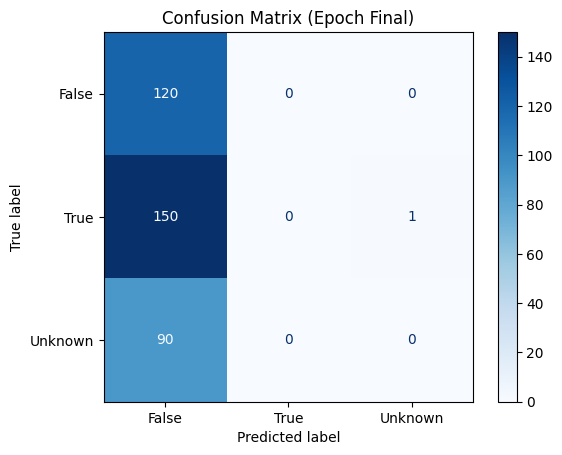

Epoch 47/100, Train Loss: 0.000142, Test Acc: 33.24% (Time: 4.64s)


Epoch 48/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

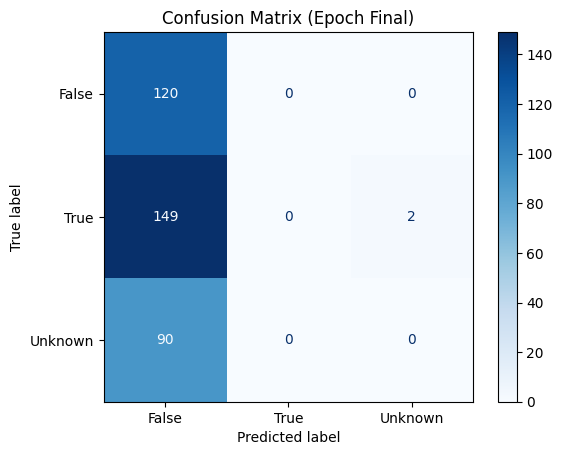

Epoch 48/100, Train Loss: 0.000095, Test Acc: 33.24% (Time: 4.30s)


Epoch 49/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

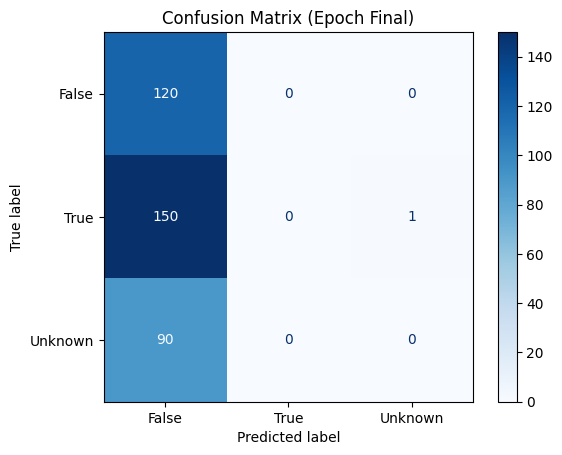

Epoch 49/100, Train Loss: 0.000069, Test Acc: 33.24% (Time: 4.59s)


Epoch 50/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

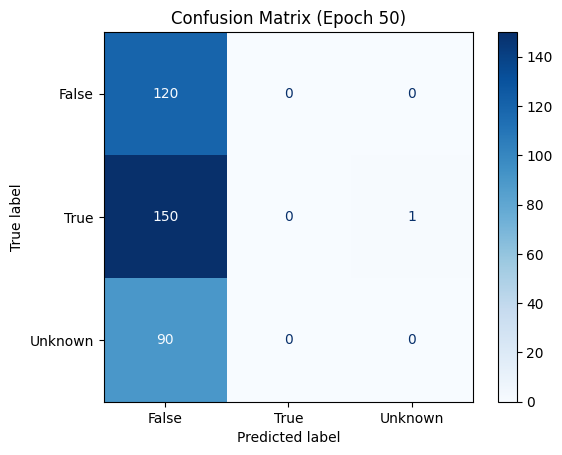

Epoch 50/100, Train Loss: 0.000071, Test Acc: 33.24% (Time: 4.36s, CM Plotted)


Epoch 51/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

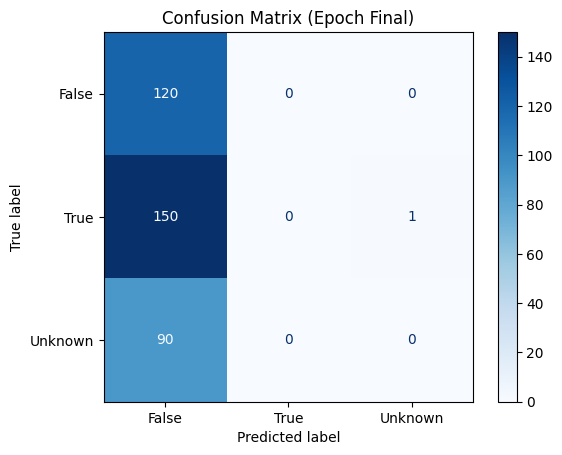

Epoch 51/100, Train Loss: 0.000059, Test Acc: 33.24% (Time: 4.67s)


Epoch 52/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

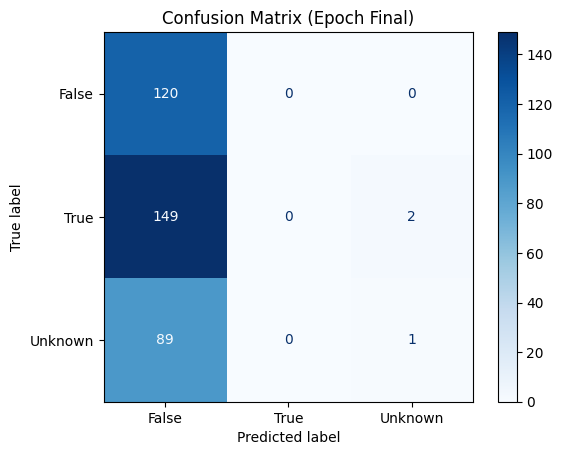

Epoch 52/100, Train Loss: 0.000079, Test Acc: 33.52% (Time: 4.24s)


Epoch 53/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

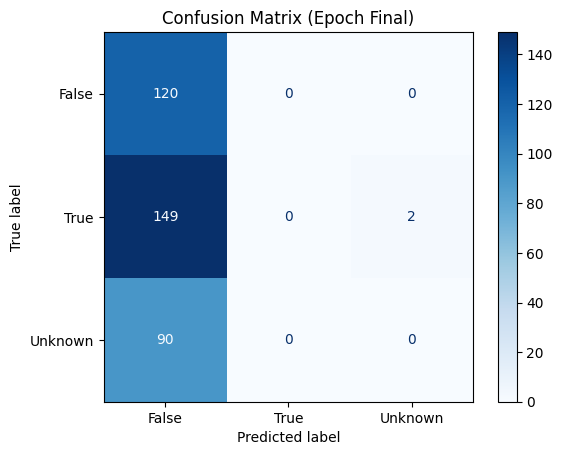

Epoch 53/100, Train Loss: 0.000071, Test Acc: 33.24% (Time: 4.77s)


Epoch 54/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

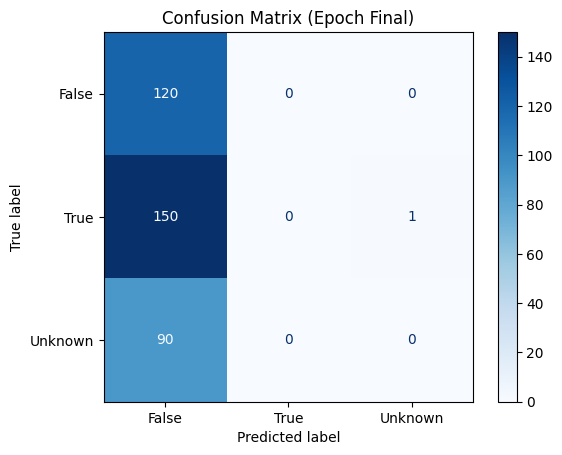

Epoch 54/100, Train Loss: 0.000067, Test Acc: 33.24% (Time: 4.33s)


Epoch 55/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

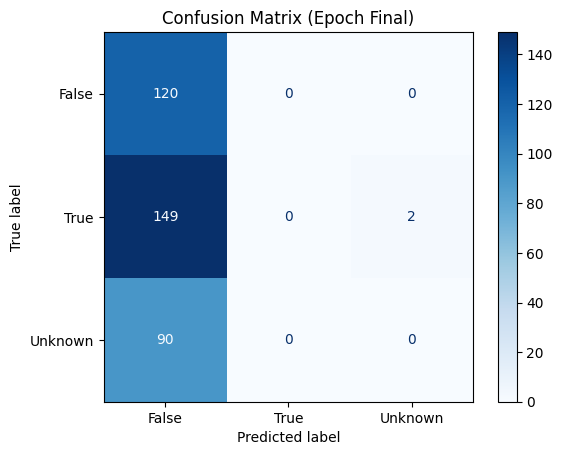

Epoch 55/100, Train Loss: 0.000052, Test Acc: 33.24% (Time: 4.85s)


Epoch 56/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

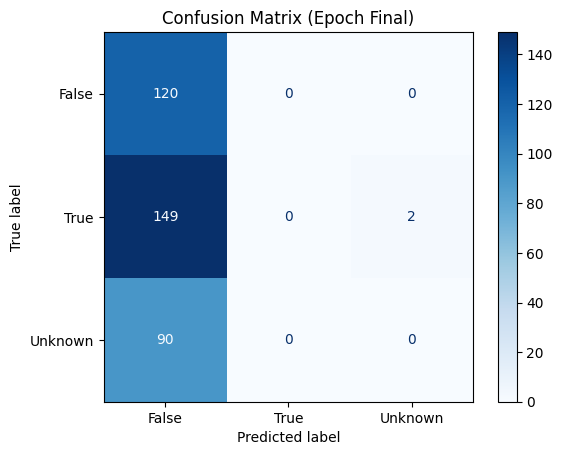

Epoch 56/100, Train Loss: 0.000071, Test Acc: 33.24% (Time: 4.40s)


Epoch 57/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

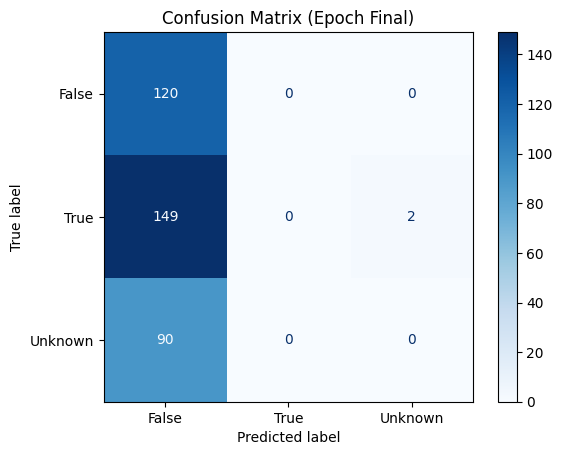

Epoch 57/100, Train Loss: 0.000076, Test Acc: 33.24% (Time: 4.72s)


Epoch 58/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

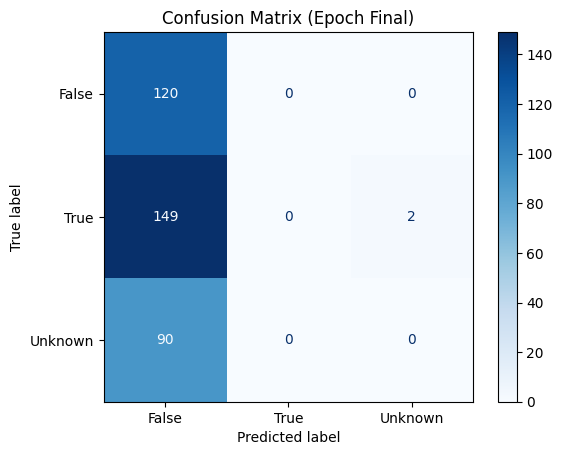

Epoch 58/100, Train Loss: 0.000056, Test Acc: 33.24% (Time: 4.31s)


Epoch 59/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

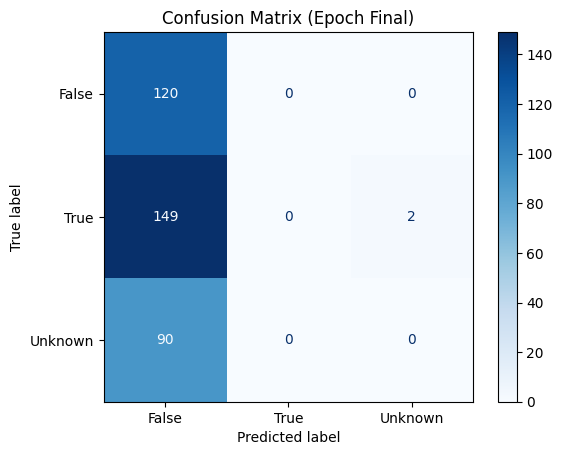

Epoch 59/100, Train Loss: 0.000071, Test Acc: 33.24% (Time: 4.95s)


Epoch 60/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

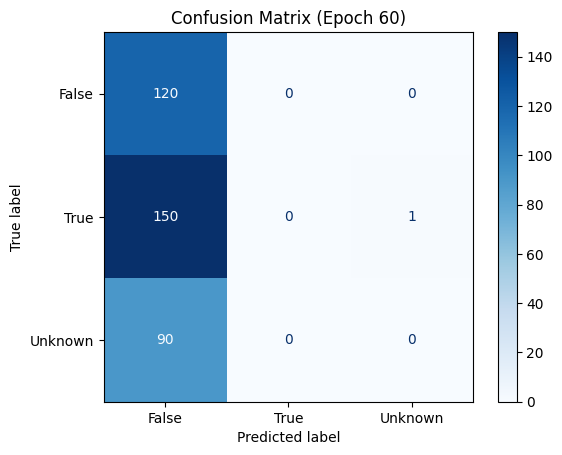

Epoch 60/100, Train Loss: 0.000045, Test Acc: 33.24% (Time: 4.37s, CM Plotted)


Epoch 61/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

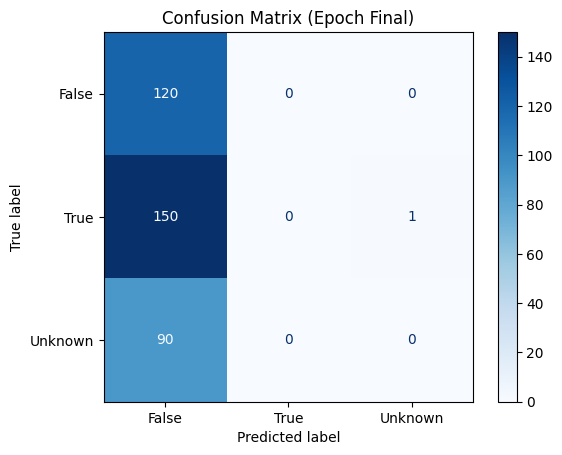

Epoch 61/100, Train Loss: 0.000065, Test Acc: 33.24% (Time: 4.74s)


Epoch 62/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

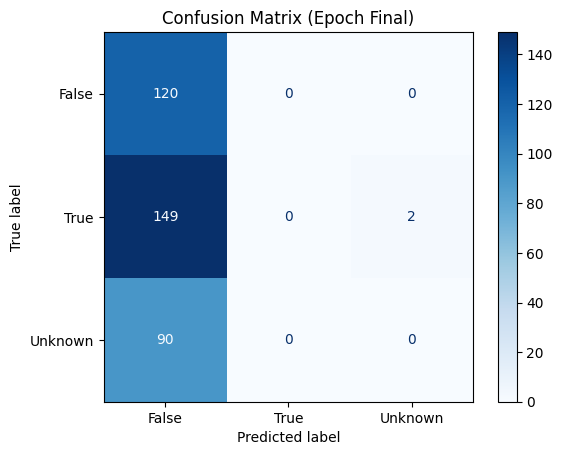

Epoch 62/100, Train Loss: 0.000048, Test Acc: 33.24% (Time: 4.45s)


Epoch 63/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

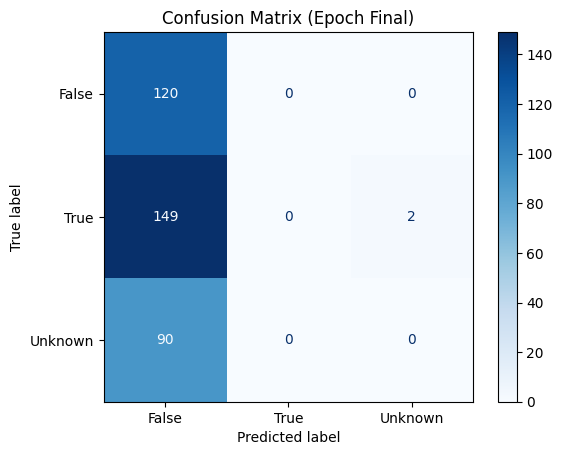

Epoch 63/100, Train Loss: 0.000094, Test Acc: 33.24% (Time: 5.67s)


Epoch 64/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

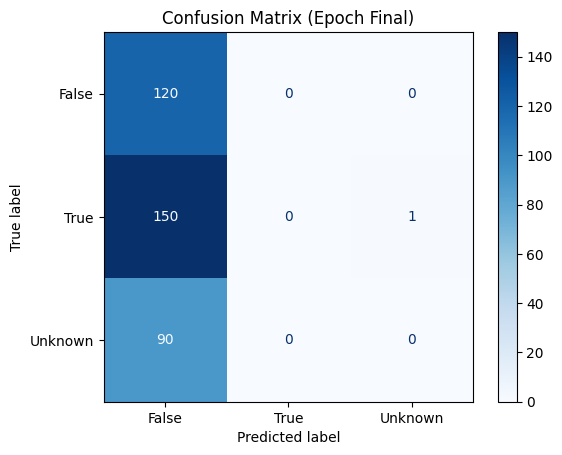

Epoch 64/100, Train Loss: 0.000050, Test Acc: 33.24% (Time: 4.40s)


Epoch 65/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

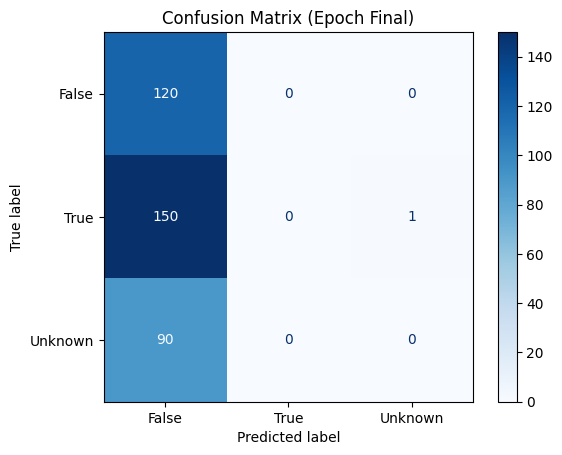

Epoch 65/100, Train Loss: 0.000057, Test Acc: 33.24% (Time: 4.89s)


Epoch 66/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

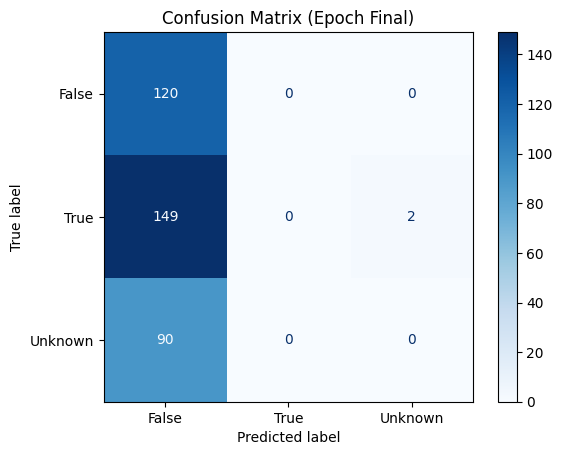

Epoch 66/100, Train Loss: 0.000052, Test Acc: 33.24% (Time: 4.38s)


Epoch 67/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

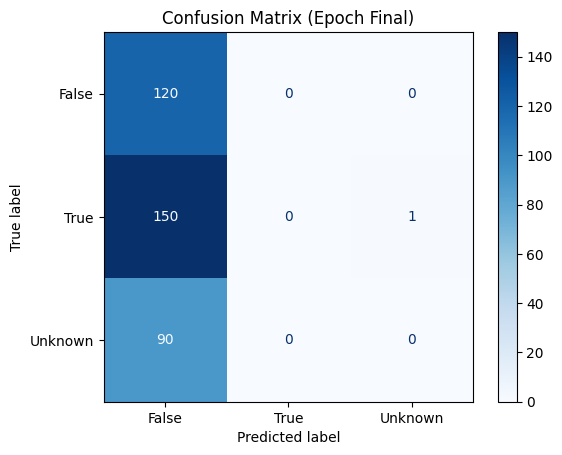

Epoch 67/100, Train Loss: 0.000049, Test Acc: 33.24% (Time: 4.95s)


Epoch 68/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

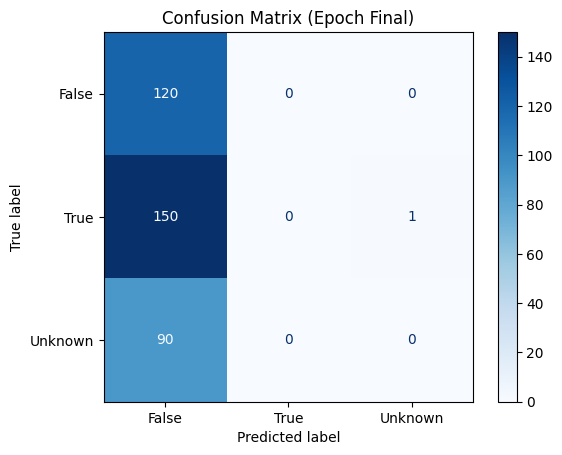

Epoch 68/100, Train Loss: 0.000045, Test Acc: 33.24% (Time: 4.46s)


Epoch 69/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

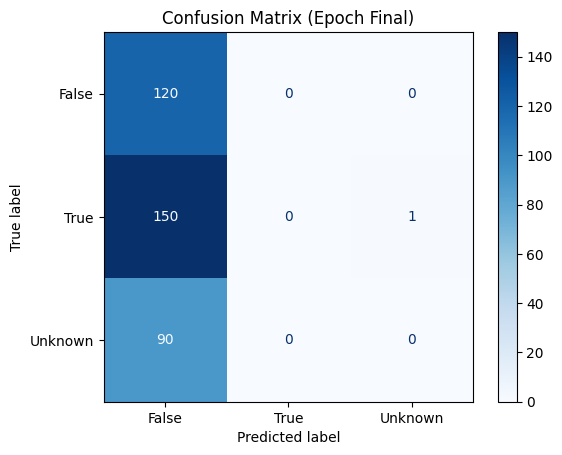

Epoch 69/100, Train Loss: 0.000090, Test Acc: 33.24% (Time: 4.79s)


Epoch 70/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

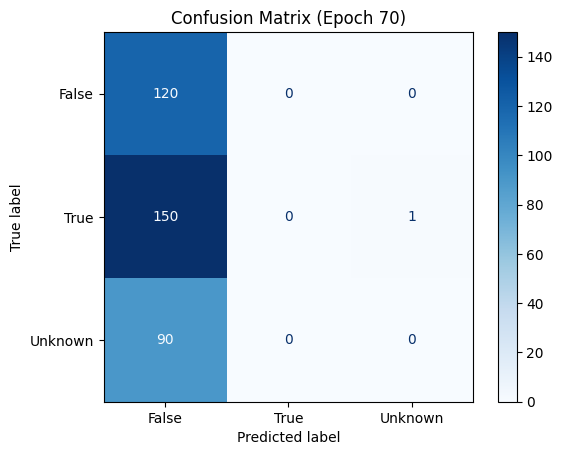

Epoch 70/100, Train Loss: 0.000041, Test Acc: 33.24% (Time: 4.40s, CM Plotted)


Epoch 71/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

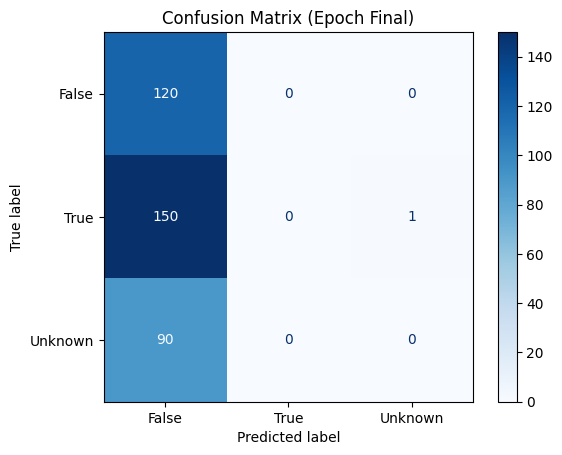

Epoch 71/100, Train Loss: 0.000064, Test Acc: 33.24% (Time: 5.02s)


Epoch 72/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

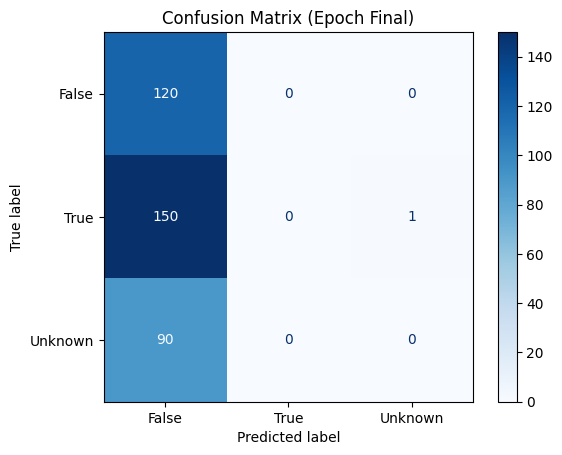

Epoch 72/100, Train Loss: 0.000077, Test Acc: 33.24% (Time: 4.45s)


Epoch 73/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

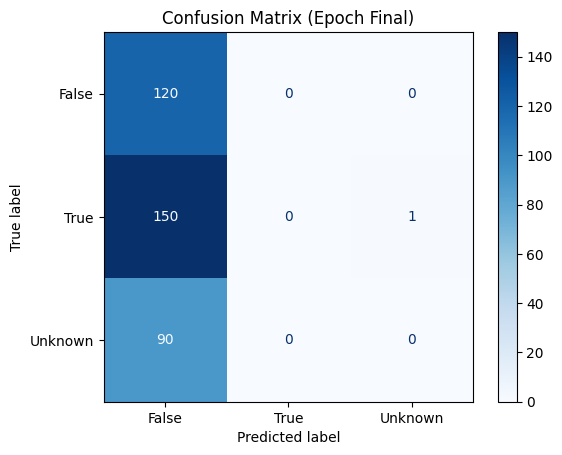

Epoch 73/100, Train Loss: 0.000035, Test Acc: 33.24% (Time: 4.70s)


Epoch 74/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

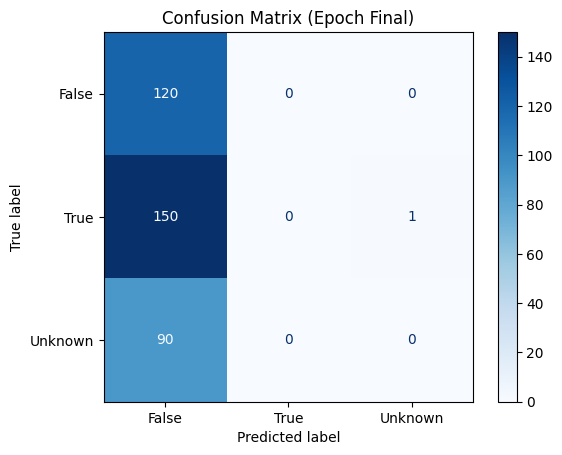

Epoch 74/100, Train Loss: 0.000044, Test Acc: 33.24% (Time: 4.53s)


Epoch 75/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

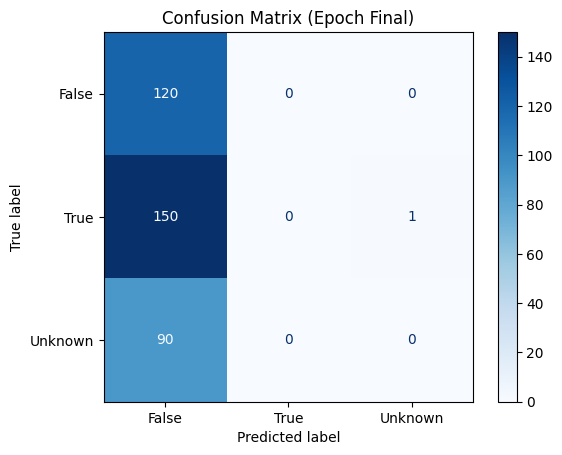

Epoch 75/100, Train Loss: 0.000041, Test Acc: 33.24% (Time: 4.73s)


Epoch 76/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

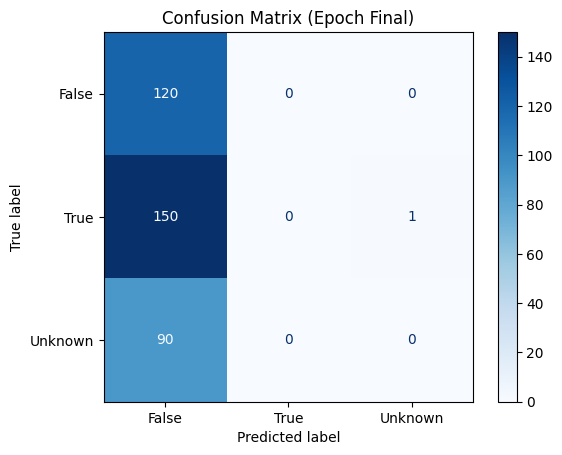

Epoch 76/100, Train Loss: 0.000034, Test Acc: 33.24% (Time: 4.48s)


Epoch 77/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

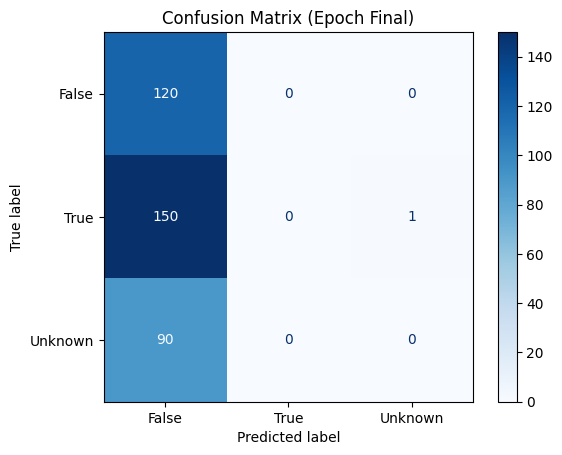

Epoch 77/100, Train Loss: 0.000036, Test Acc: 33.24% (Time: 4.97s)


Epoch 78/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

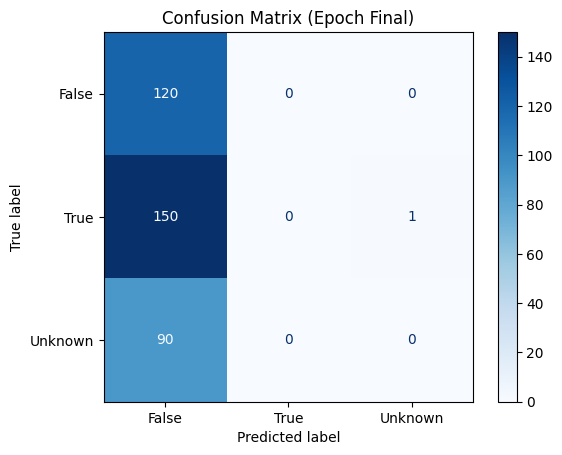

Epoch 78/100, Train Loss: 0.000101, Test Acc: 33.24% (Time: 4.42s)


Epoch 79/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

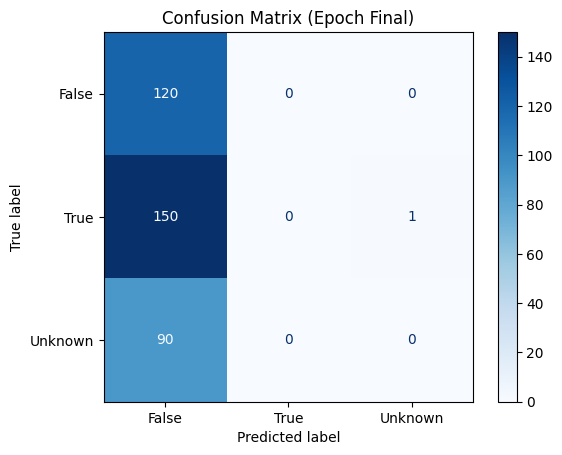

Epoch 79/100, Train Loss: 0.000038, Test Acc: 33.24% (Time: 4.88s)


Epoch 80/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

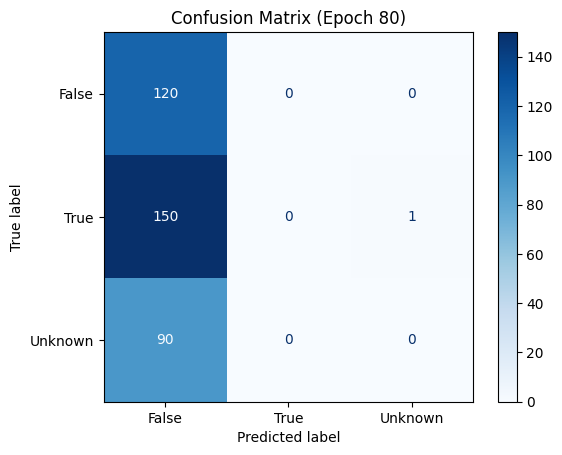

Epoch 80/100, Train Loss: 0.000039, Test Acc: 33.24% (Time: 4.49s, CM Plotted)


Epoch 81/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

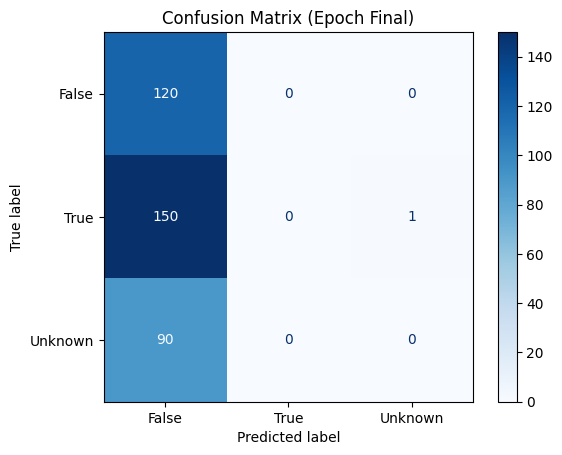

Epoch 81/100, Train Loss: 0.000029, Test Acc: 33.24% (Time: 4.92s)


Epoch 82/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

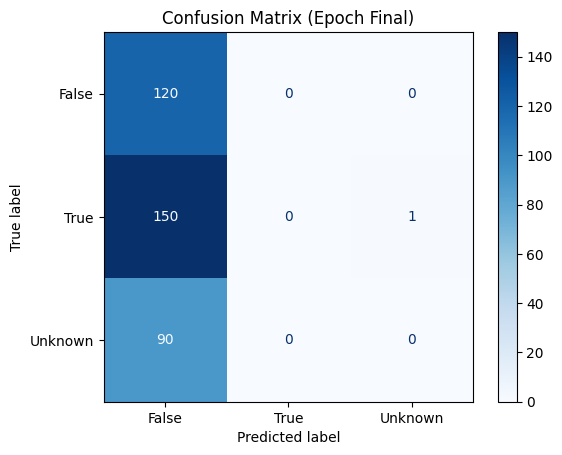

Epoch 82/100, Train Loss: 0.000044, Test Acc: 33.24% (Time: 4.41s)


Epoch 83/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

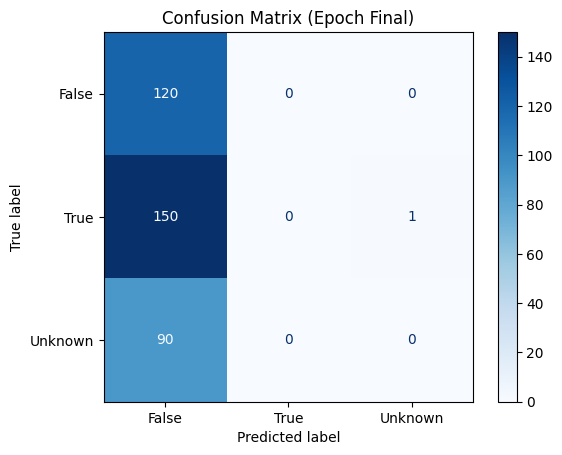

Epoch 83/100, Train Loss: 0.000036, Test Acc: 33.24% (Time: 5.16s)


Epoch 84/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

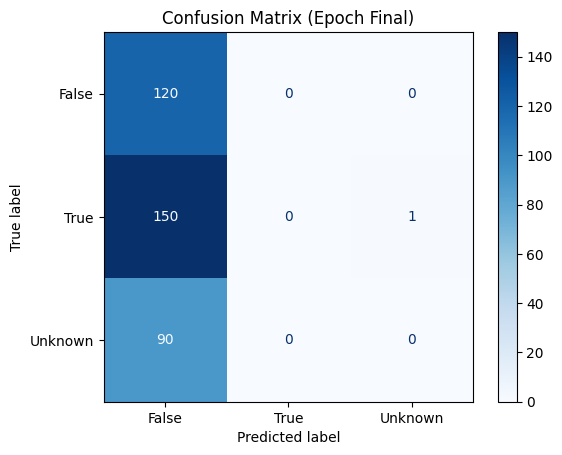

Epoch 84/100, Train Loss: 0.000045, Test Acc: 33.24% (Time: 4.41s)


Epoch 85/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

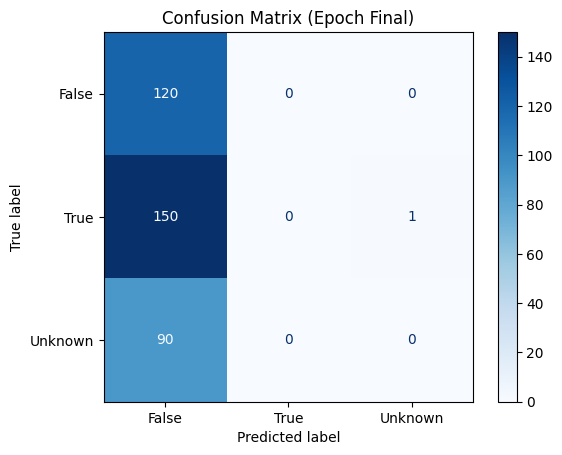

Epoch 85/100, Train Loss: 0.000037, Test Acc: 33.24% (Time: 5.08s)


Epoch 86/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

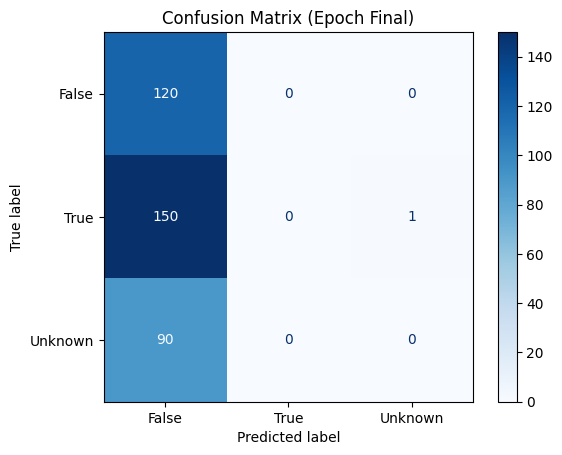

Epoch 86/100, Train Loss: 0.000054, Test Acc: 33.24% (Time: 4.47s)


Epoch 87/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

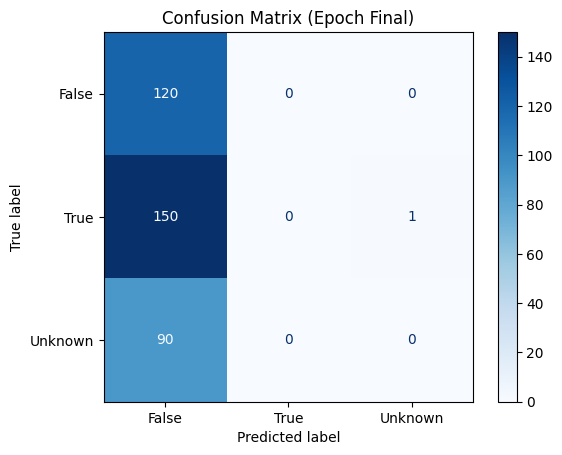

Epoch 87/100, Train Loss: 0.000037, Test Acc: 33.24% (Time: 5.05s)


Epoch 88/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

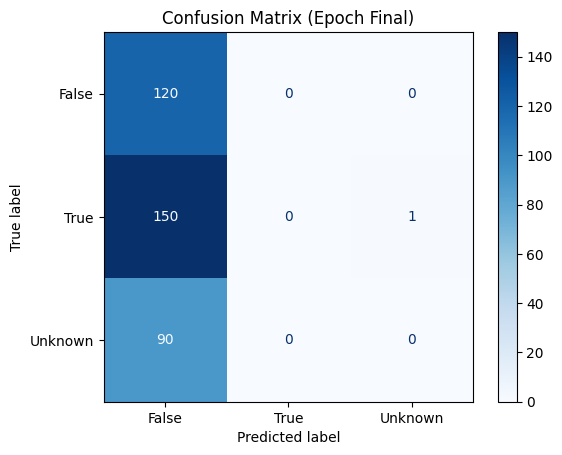

Epoch 88/100, Train Loss: 0.000053, Test Acc: 33.24% (Time: 4.43s)


Epoch 89/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

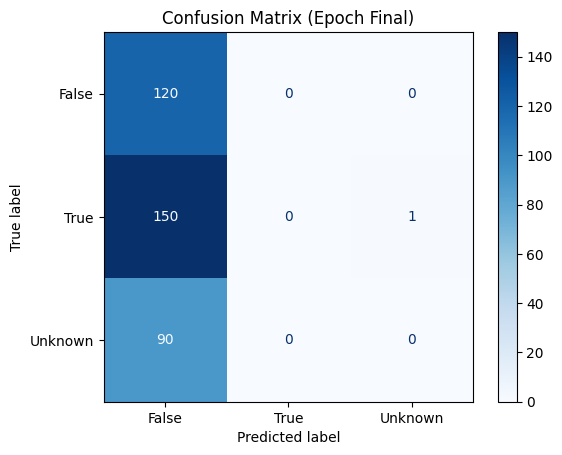

Epoch 89/100, Train Loss: 0.000039, Test Acc: 33.24% (Time: 5.09s)


Epoch 90/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

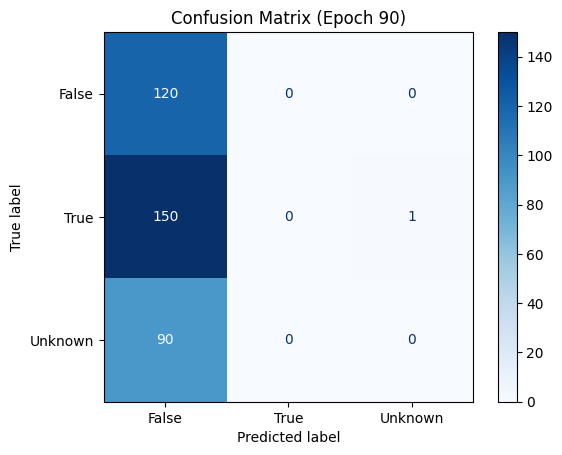

Epoch 90/100, Train Loss: 0.000025, Test Acc: 33.24% (Time: 4.43s, CM Plotted)


Epoch 91/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

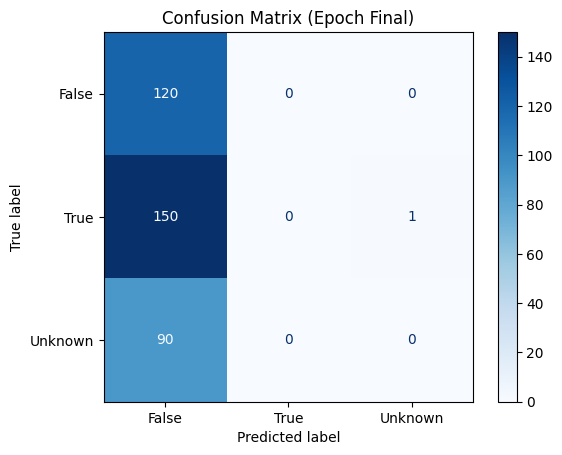

Epoch 91/100, Train Loss: 0.000044, Test Acc: 33.24% (Time: 5.13s)


Epoch 92/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

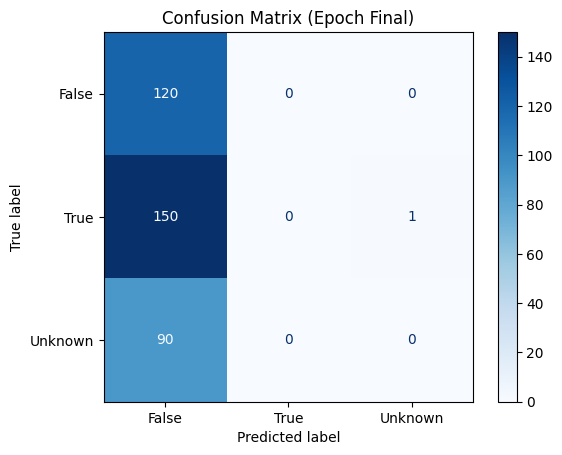

Epoch 92/100, Train Loss: 0.000089, Test Acc: 33.24% (Time: 4.62s)


Epoch 93/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

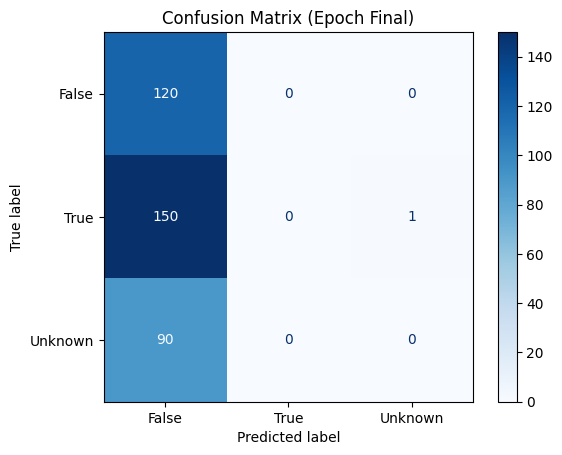

Epoch 93/100, Train Loss: 0.000072, Test Acc: 33.24% (Time: 5.61s)


Epoch 94/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

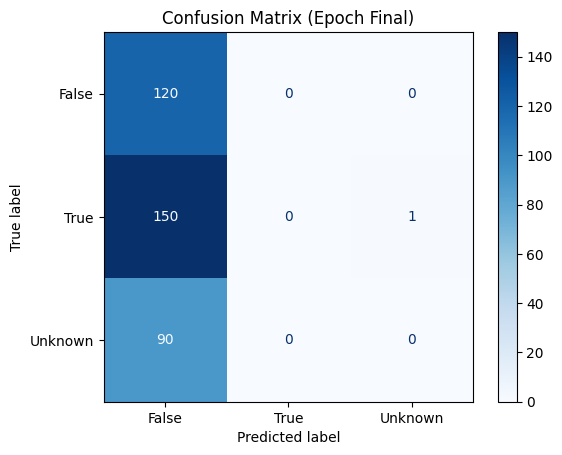

Epoch 94/100, Train Loss: 0.000157, Test Acc: 33.24% (Time: 4.61s)


Epoch 95/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

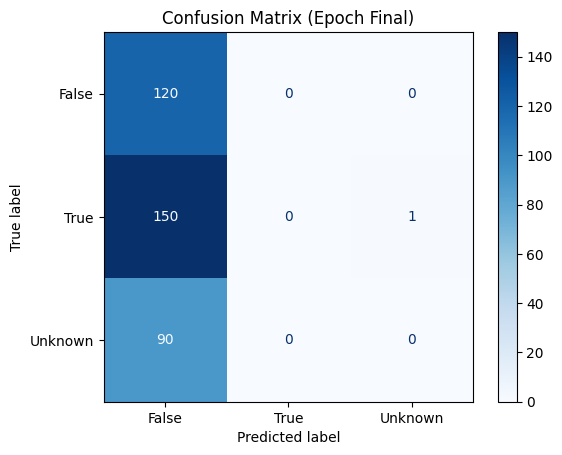

Epoch 95/100, Train Loss: 0.000034, Test Acc: 33.24% (Time: 6.43s)


Epoch 96/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

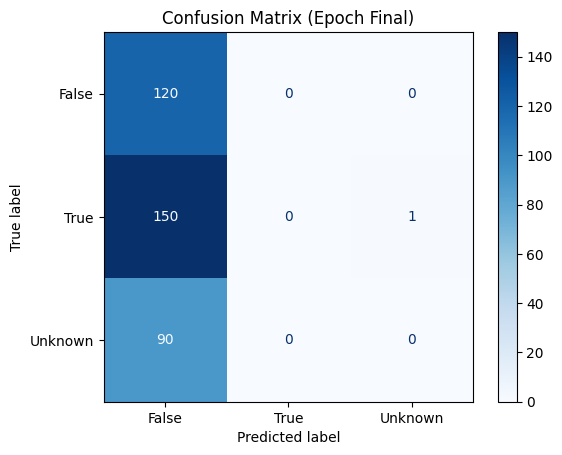

Epoch 96/100, Train Loss: 0.000035, Test Acc: 33.24% (Time: 4.50s)


Epoch 97/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

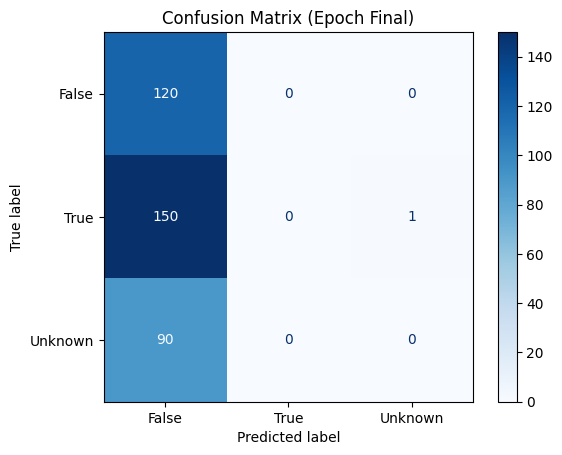

Epoch 97/100, Train Loss: 0.000041, Test Acc: 33.24% (Time: 5.06s)


Epoch 98/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

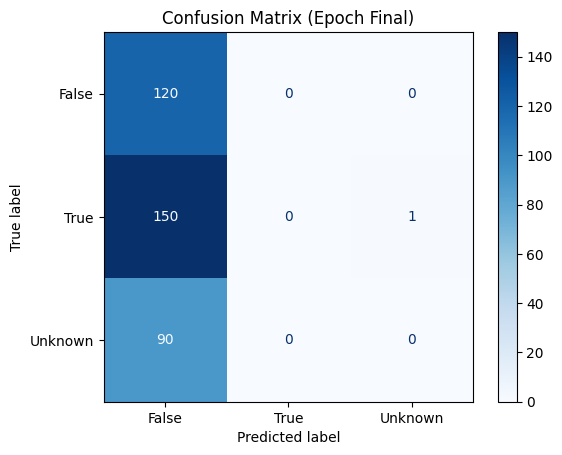

Epoch 98/100, Train Loss: 0.000032, Test Acc: 33.24% (Time: 4.50s)


Epoch 99/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

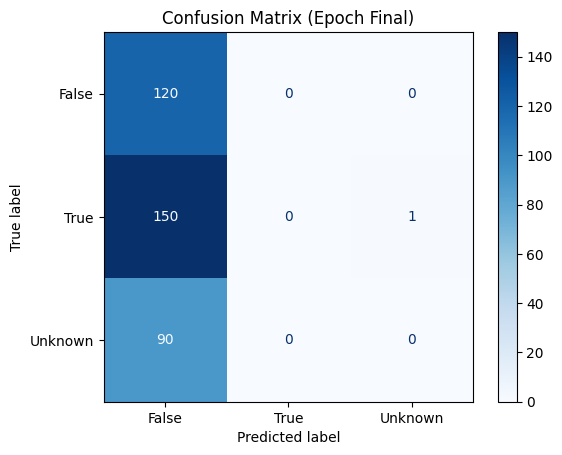

Epoch 99/100, Train Loss: 0.000028, Test Acc: 33.24% (Time: 5.12s)


Epoch 100/100:   0%|          | 0/5 [00:00<?, ?it/s]

--------------------


<Figure size 800x600 with 0 Axes>

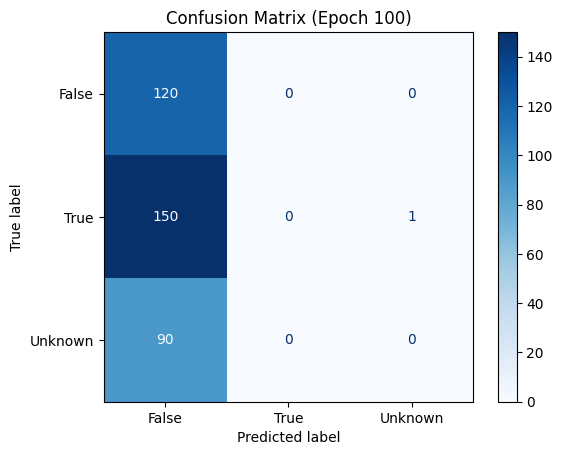

Epoch 100/100, Train Loss: 0.000038, Test Acc: 33.24% (Time: 4.47s, CM Plotted)


In [7]:
# train.py (Confusion Matrix 출력 기능 추가)
if __name__ == "__main__":
    # --- 6. 학습 루프 및 모델 저장 (수정) ---
    start = time.time()
    print("\n 학습 시작 \n")

    best_accuracy = 0.0

    # 클래스 이름을 저장하여 test.py에서 사용할 수 있도록 함
    with open('class_names.txt', 'w') as f:
        for name in class_names:
            f.write(f"{name}\n")

    for i in tqdm(range(num_epoch), desc="Total Training"):
        epoch_start_time = time.time()
        model.train()
        total_loss = 0.0

        epoch_iterator = tqdm(train_loader, desc=f"Epoch {i+1}/{num_epoch}", leave=False)

        for _,[image,label] in enumerate(epoch_iterator):
            x = image.to(device)
            y_= label.to(device)

            optimizer.zero_grad()
            output = model.forward(x)
            loss = loss_func(output,y_)
            loss.backward()
            optimizer.step()

            current_loss = loss.item()
            total_loss += current_loss

            epoch_iterator.set_postfix({"Loss": f"{current_loss:.4f}"})

        avg_loss = total_loss / len(train_loader)
        epoch_elapsed_time = time.time() - epoch_start_time

        print("--" * 10)

        # 매 에폭마다 테스트 성능 출력 (Confusion Matrix는 10 에폭마다 출력하도록 조정)
        if (i + 1) % 10 == 0 or (i == num_epoch - 1):
            test_accuracy = validate_model(model, test_loader, device, class_names, epoch_num=i + 1)
            print(f"Epoch {i+1}/{num_epoch}, Train Loss: {avg_loss:.6f}, Test Acc: {test_accuracy:.2f}% (Time: {epoch_elapsed_time:.2f}s, CM Plotted)")
        else:
            test_accuracy = validate_model(model, test_loader, device, class_names)
            print(f"Epoch {i+1}/{num_epoch}, Train Loss: {avg_loss:.6f}, Test Acc: {test_accuracy:.2f}% (Time: {epoch_elapsed_time:.2f}s)")


        # 베스트 모델 저장
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            torch.save(model.state_dict(), FILE_PATH)
            print(f"-> Model saved with improved accuracy: {best_accuracy:.2f}%")


    # print("\n 학습 완료 \n\n")
    # print("--------------------------------------------------")
    # print("\n 최종 결과 \n")
    # print("Best Accurary of Test Data: {:.2f}%".format(best_accuracy))
    # print("Total elapsed time: {:.2f} seconds".format(time.time() - start))

In [8]:
print("\n 학습 완료 \n\n")
print("--------------------------------------------------")
print("\n 최종 결과 \n")
print("Best Accurary of Test Data: {:.2f}%".format(best_accuracy))
print("Total elapsed time: {:.2f} seconds".format(time.time() - start))


 학습 완료 


--------------------------------------------------

 최종 결과 

Best Accurary of Test Data: 35.18%
Total elapsed time: 685.99 seconds
